## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction= 0.333 )  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Skyno\Anaco

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout, regularizers

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0.,
              l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)

            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 128

"""
建立實驗組合
"""
USE_BN = [True, False]
DRP_RATIO = [0., 0.4, 0.8]
L2_RATIO = [0., 1e-6, 1e-8]

In [7]:
import keras.backend as K

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    K.clear_session()
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("bn: %s, drp: %.2f, l2: %.2f" % (use_bn, drp_ratio, l2_ratio))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0808 20:15:42.668694 14528 deprecation_wrapper.py:119] From C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0808 20:15:42.669670 14528 deprecation_wrapper.py:119] From C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 20:15:42.672598 14528 deprecation_wrapper.py:119] From C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 20:15:42.673575 14528 deprecation_wrapper.py:119] From C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprec

Numbers of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00


W0808 20:15:42.883413 14528 deprecation_wrapper.py:119] From C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 20:15:42.954687 14528 deprecation.py:323] From C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 112us/step - loss: 1.6167 - acc: 0.4262 - val_loss: 1.7900 - val_acc: 0.3726
Epoch 2/20
50000/50000 [==============================] - 4s 89us/step - loss: 1.3808 - acc: 0.5072 - val_loss: 1.6861 - val_acc: 0.3847
Epoch 3/20
50000/50000 [==============================] - 4s 86us/step - loss: 1.2622 - acc: 0.5498 - val_loss: 1.5647 - val_acc: 0.4412
Epoch 4/20
50000/50000 [==============================] - 4s 87us/step - loss: 1.1698 - acc: 0.5850 - val_loss: 1.5513 - val_acc: 0.4500
Epoch 5/20
50000/50000 [==============================] - 4s 88us/step - loss: 1.0968 - acc: 0.6126 - val_loss: 1.6420 - val_acc: 0.4342
Epoch 6/20
50000/50000 [==============================] - 4s 89us/step - loss: 1.0168 - acc: 0.6384 - val_loss: 1.6470 - val_acc: 0.4229
Epoch 7/20
50000/50000 [==============================] - 4s 85us/step - loss: 0.9470 - acc: 0.6629 - val_loss: 1.7908 - val_ac

50000/50000 [==============================] - 5s 91us/step - loss: 0.3400 - acc: 0.8800 - val_loss: 2.0243 - val_acc: 0.4998
Epoch 19/20
50000/50000 [==============================] - 5s 93us/step - loss: 0.3077 - acc: 0.8929 - val_loss: 2.2616 - val_acc: 0.4869
Epoch 20/20
50000/50000 [==============================] - 5s 92us/step - loss: 0.2875 - acc: 0.8983 - val_loss: 2.8833 - val_acc: 0.4330


W0808 20:20:21.972977 14528 deprecation.py:506] From C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Numbers of exp: 3, with bn: True, drp_ratio: 0.40, l2_ratio: 0.00
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 108us/step - loss: 1.9426 - acc: 0.3083 - val_loss: 1.7041 - val_acc: 0.3833
Epoch 2/20
50000/50000 [==============================] - 4s 88us/step - loss: 1.6754 - acc: 0.3985 - val_loss: 1.6644 - val_acc: 0.4147
Epoch 3/20
50000/50000 [==============================] - 4s 88us/step - loss: 1.5908 - acc: 0.4334 - val_loss: 1.6752 - val_acc: 0.4023
Epoch 4/20
50000/50000 [==============================] - 4s 89us/step - loss: 1.5276 - acc: 0.4553 - val_loss: 1.6540 - val_acc: 0.4036
Epoch 5/20
50000/50000 [==============================] - 5s 92us/step - loss: 1.4868 - acc: 0.4714 - val_loss: 1.5057 - val_acc: 0.4661
Epoch 6/20
50000/50000 [==============================] - 5s 91us/step - loss: 1.4507 - acc: 0.4832 - val_loss: 1.7170 - val_acc: 0.3829
Epoch 7/20
50000/50000 [==============================] - 4s 

Epoch 18/20
50000/50000 [==============================] - 5s 101us/step - loss: 1.1939 - acc: 0.5774 - val_loss: 1.4163 - val_acc: 0.4923
Epoch 19/20
50000/50000 [==============================] - 5s 97us/step - loss: 1.1734 - acc: 0.5864 - val_loss: 1.4496 - val_acc: 0.4845
Epoch 20/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.1642 - acc: 0.5884 - val_loss: 1.3696 - val_acc: 0.5115


W0808 20:25:11.432881 14528 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0808 20:25:11.503152 14528 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Numbers of exp: 6, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00


W0808 20:25:11.584160 14528 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 110us/step - loss: 2.7188 - acc: 0.1338 - val_loss: 2.1205 - val_acc: 0.2718
Epoch 2/20
50000/50000 [==============================] - 5s 93us/step - loss: 2.1393 - acc: 0.1924 - val_loss: 1.9808 - val_acc: 0.2675
Epoch 3/20
50000/50000 [==============================] - 5s 94us/step - loss: 2.0299 - acc: 0.2307 - val_loss: 1.9099 - val_acc: 0.2831
Epoch 4/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.9833 - acc: 0.2464 - val_loss: 1.8905 - val_acc: 0.2909
Epoch 5/20
50000/50000 [==============================] - 5s 96us/step - loss: 1.9561 - acc: 0.2565 - val_loss: 1.8458 - val_acc: 0.3144
Epoch 6/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.9322 - acc: 0.2673 - val_loss: 1.8174 - val_acc: 0.3279
Epoch 7/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.9106 - acc: 0.2772 - val_loss: 1.8315 - val_ac

W0808 20:26:46.897371 14528 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0808 20:26:46.969594 14528 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Numbers of exp: 7, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 113us/step - loss: 2.6920 - acc: 0.1355 - val_loss: 2.1258 - val_acc: 0.2391
Epoch 2/20
50000/50000 [==============================] - 5s 93us/step - loss: 2.1433 - acc: 0.1919 - val_loss: 1.9871 - val_acc: 0.2677
Epoch 3/20
50000/50000 [==============================] - 5s 94us/step - loss: 2.0379 - acc: 0.2265 - val_loss: 1.9133 - val_acc: 0.3014
Epoch 4/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.9875 - acc: 0.2435 - val_loss: 1.8815 - val_acc: 0.2774
Epoch 5/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.9623 - acc: 0.2504 - val_loss: 1.8408 - val_acc: 0.3239
Epoch 6/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.9402 - acc: 0.2650 - val_loss: 1.8280 - val_acc: 0.3095
Epoch 7/20
50000/50000 [==============================] - 5s 

50000/50000 [==============================] - 3s 64us/step - loss: 1.1476 - acc: 0.5886 - val_loss: 1.3846 - val_acc: 0.5210
Epoch 19/20
50000/50000 [==============================] - 3s 63us/step - loss: 1.1251 - acc: 0.5952 - val_loss: 1.3680 - val_acc: 0.5229
Epoch 20/20
50000/50000 [==============================] - 3s 64us/step - loss: 1.1028 - acc: 0.6050 - val_loss: 1.3935 - val_acc: 0.5225
Numbers of exp: 10, with bn: False, drp_ratio: 0.00, l2_ratio: 0.00
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.8874 - acc: 0.3190 - val_loss: 1.7080 - val_acc: 0.3823
Epoch 2/20
50000/50000 [==============================] - 3s 68us/step - loss: 1.6837 - acc: 0.3974 - val_loss: 1.6344 - val_acc: 0.4154
Epoch 3/20
50000/50000 [==============================] - 3s 67us/step - loss: 1.5953 - acc: 0.4299 - val_loss: 1.5666 - val_acc: 0.4397
Epoch 4/20
50000/50000 [==============================] - 3s 67us/ste

50000/50000 [==============================] - 3s 65us/step - loss: 1.8682 - acc: 0.3082 - val_loss: 1.8390 - val_acc: 0.3585
Epoch 16/20
50000/50000 [==============================] - 3s 65us/step - loss: 1.8580 - acc: 0.3157 - val_loss: 1.8039 - val_acc: 0.3802
Epoch 17/20
50000/50000 [==============================] - 3s 65us/step - loss: 1.8618 - acc: 0.3172 - val_loss: 1.8170 - val_acc: 0.3729
Epoch 18/20
50000/50000 [==============================] - 3s 66us/step - loss: 1.8519 - acc: 0.3210 - val_loss: 1.7777 - val_acc: 0.3786
Epoch 19/20
50000/50000 [==============================] - 3s 65us/step - loss: 1.8559 - acc: 0.3198 - val_loss: 1.7962 - val_acc: 0.3745
Epoch 20/20
50000/50000 [==============================] - 3s 65us/step - loss: 1.8489 - acc: 0.3221 - val_loss: 1.8331 - val_acc: 0.3406
Numbers of exp: 13, with bn: False, drp_ratio: 0.40, l2_ratio: 0.00
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 80us/

50000/50000 [==============================] - 3s 62us/step - loss: 2.3028 - acc: 0.0966 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 13/20
50000/50000 [==============================] - 3s 64us/step - loss: 2.3028 - acc: 0.0975 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 14/20
50000/50000 [==============================] - 3s 65us/step - loss: 2.3027 - acc: 0.0973 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 15/20
50000/50000 [==============================] - 3s 66us/step - loss: 2.3027 - acc: 0.0972 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 16/20
50000/50000 [==============================] - 3s 68us/step - loss: 2.3027 - acc: 0.0969 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 17/20
50000/50000 [==============================] - 3s 67us/step - loss: 2.3027 - acc: 0.0961 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 18/20
50000/50000 [==============================] - 3s 66us/step - loss: 2.3027 - acc: 0.0987 - val_loss: 2.3026 - val_acc: 0.0999
Epoch 19/20
50000/50000 [=====================

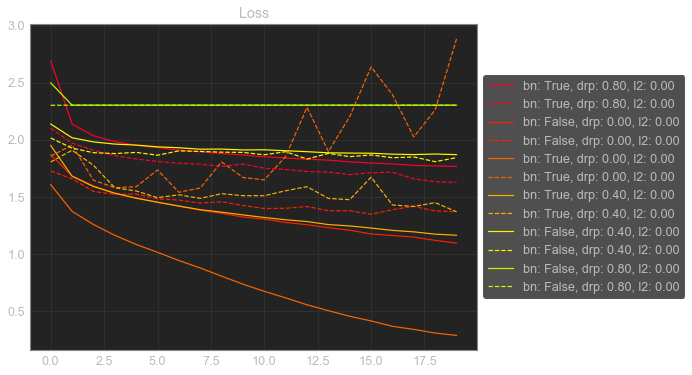

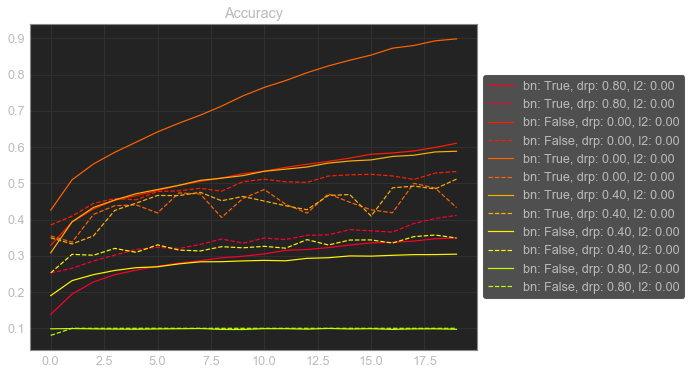

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig("EXP_loss.png", bbox_inches='tight', dpi=300)


fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig("EXP_acc.png", bbox_inches='tight', dpi=300)
